In [1]:
%load_ext sql

In [2]:
%sql postgresql://postgres@localhost:5432/global_football_goalscorers

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Check all matches between two countries in history.

In [4]:
%%sql
DROP FUNCTION IF EXISTS check_matches(varchar(64), varchar(64));
CREATE OR REPLACE FUNCTION check_matches(team1 varchar(64), team2 varchar(64))
RETURNS TABLE (
    home_team varchar(64),
    away_team varchar(64),
    date date,
    home_score int, 
    away_score int, 
    winner varchar(64),
    tournament varchar(64),
    former varchar(64)
) AS $$
BEGIN
    RETURN QUERY
    WITH found_match AS(
        SELECT r.home_team, r.away_team, r.date, r.home_score, r.away_score, r.tournament
        FROM results r 
        WHERE (r.home_team=team1 AND r.away_team=team2) OR (r.home_team=team2 AND r.away_team=team1)
    ) 
    SELECT r.home_team, r.away_team, r.date, r.home_score, r.away_score, 
        CASE
            WHEN r.home_score > r.away_score THEN r.home_team
            WHEN r.home_score < r.away_score THEN r.away_team
            ELSE 'Tie'
        END AS winner,
        r.tournament, 
        CASE 
            WHEN r.date >= fn.start_date AND r.date <= fn.end_date THEN fn.former
            ELSE NULL
        END AS former_name_at_match
    FROM found_match r 
    JOIN countries ht ON r.away_team=ht.country_name 
    JOIN countries at ON r.away_team=at.country_name
    JOIN former_names fn ON ht.country_name=fn.current
    ORDER BY r.date;
END;
$$ LANGUAGE plpgsql;


 * postgresql://postgres@localhost:5432/global_football_goalscorers
Done.
Done.


[]

In [5]:
%sql select * from check_matches('Russia', 'Sweden');

 * postgresql://postgres@localhost:5432/global_football_goalscorers
32 rows affected.


home_team,away_team,date,home_score,away_score,winner,tournament,former
Sweden,Russia,1914-07-05,2,2,Tie,Friendly,None
Sweden,Russia,1914-07-05,2,2,Tie,Friendly,None
Sweden,Russia,1955-06-26,0,6,Russia,Friendly,None
Sweden,Russia,1955-06-26,0,6,Russia,Friendly,Soviet Union
Sweden,Russia,1958-06-19,2,0,Sweden,FIFA World Cup,None
Sweden,Russia,1958-06-19,2,0,Sweden,FIFA World Cup,Soviet Union
Sweden,Russia,1962-04-18,0,2,Russia,Friendly,None
Sweden,Russia,1962-04-18,0,2,Russia,Friendly,Soviet Union
Sweden,Russia,1964-05-13,1,1,Tie,UEFA Euro qualification,None
Sweden,Russia,1964-05-13,1,1,Tie,UEFA Euro qualification,Soviet Union


#### Find out matches whose scorers are not recorded

In [8]:
%%sql
DROP VIEW IF EXISTS incomplete_info; 

DO $$
DECLARE 
    results_cols text;
    sql text;
BEGIN
    SELECT string_agg('r.' || column_name, ', ' ORDER BY ordinal_position)
    INTO results_cols
    FROM information_schema.columns
    WHERE table_name = 'results';

    sql := format($f$
        CREATE OR REPLACE VIEW incomplete_info AS
        SELECT %s, g.team, g.scorer, g.minute, g.own_goal, g.penalty
        FROM results r
        JOIN countries ht ON r.home_team = ht.country_name
        JOIN countries at ON r.away_team = at.country_name
        LEFT JOIN goalscorers g
            ON g.home_team = ht.country_name
           AND g.away_team = at.country_name
        WHERE r.home_score<>0 and r.away_score <> 0 and g.team IS NULL
    $f$, results_cols);

    RAISE NOTICE 'EXECUTING: %', sql;

    EXECUTE sql;
END $$;


 * postgresql://postgres@localhost:5432/global_football_goalscorers
Done.
Done.


[]

In [9]:
# Show the first 10 matches whose record are not complete
%sql SELECT * FROM incomplete_info LIMIT 10;


 * postgresql://postgres@localhost:5432/global_football_goalscorers
10 rows affected.


id,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,team,scorer,minute,own_goal,penalty
36242,2012-09-25,Abkhazia,Artsakh,1,1,Friendly,Sukhumi,Georgia,False,tied,None,None,None,None,None
40872,2017-08-31,Abkhazia,Donetsk PR,1,2,Friendly,Sukhumi,Georgia,False,Donetsk PR,None,None,None,None,None
41522,2018-06-03,Abkhazia,Northern Cyprus,2,2,CONIFA World Football Cup,Enfield,England,True,tied,None,None,None,None,None
40581,2017-06-05,Abkhazia,South Ossetia,2,1,CONIFA European Football Cup,Kyrenia,Northern Cyprus,True,Abkhazia,None,None,None,None,None
42451,2019-06-06,Abkhazia,Western Armenia,1,1,CONIFA European Football Cup,Stepanakert,Azerbaijan,True,tied,None,None,None,None,None
31975,2008-06-08,Afghanistan,Bhutan,1,3,SAFF Cup,Colombo,Sri Lanka,True,Bhutan,None,None,None,None,None
40584,2017-06-06,Afghanistan,Maldives,2,1,Friendly,Dubai,United Arab Emirates,True,Afghanistan,None,None,None,None,None
40489,2017-03-28,Afghanistan,Vietnam,1,1,AFC Asian Cup qualification,Dushanbe,Tajikistan,True,tied,None,None,None,None,None
46236,2023-07-13,Åland Islands,Falkland Islands,1,1,Island Games,Saint Sampson,Guernsey,True,tied,None,None,None,None,None
33093,2009-06-28,Åland Islands,Greenland,4,2,Island Games,Mariehamn,Sweden,False,Åland Islands,None,None,None,None,None


#### Find out the top 5 goalscorers in the history

In [10]:
%%sql 
SELECT scorer, team, count(scorer) as total_goals
FROM goalscorers 
WHERE own_goal=FALSE
GROUP BY scorer, team
ORDER BY total_goals DESC
LIMIT 5;


 * postgresql://postgres@localhost:5432/global_football_goalscorers
5 rows affected.


scorer,team,total_goals
Cristiano Ronaldo,Portugal,108
Robert Lewandowski,Poland,63
Romelu Lukaku,Belgium,60
Harry Kane,England,58
Lionel Messi,Argentina,55


#### Find out the team who has won the most for a given tournament

In [ ]:
%%sql 
--add a column for winning_team
ALTER TABLE results 
ADD COLUMN winning_team varchar(64);

UPDATE results
SET winning_team=CASE
    WHEN home_score > away_score THEN home_team
    WHEN home_score < away_score THEN away_team
    ELSE 'tied'
END;



In [12]:
%%sql
DROP FUNCTION IF EXISTS champion;
CREATE OR REPLACE FUNCTION champion(tournament_name varchar(64))
RETURNS TABLE (
    tournament varchar(64),
    winning_team varchar(64),
    times_of_winning bigint
) AS $$
BEGIN
    RETURN QUERY
    SELECT r.tournament, r.winning_team, count(r.winning_team) AS times_of_winning
    FROM results r
    WHERE r.tournament=tournament_name and r.winning_team<>'tied'
    GROUP BY r.tournament, r.winning_team
    ORDER BY times_of_winning DESC
    LIMIT 1;
END;
$$ LANGUAGE plpgsql;

 * postgresql://postgres@localhost:5432/global_football_goalscorers
Done.
Done.


[]

In [13]:
%sql SELECT * FROM champion('FIFA World Cup');

 * postgresql://postgres@localhost:5432/global_football_goalscorers
1 rows affected.


tournament,winning_team,times_of_winning
FIFA World Cup,Brazil,76


#### Exploratory data analysis

In [14]:
# import data into a dataframe
%sql query_results << SELECT * FROM results;

results_df = query_results.DataFrame()
display(results_df.dtypes)

 * postgresql://postgres@localhost:5432/global_football_goalscorers
48673 rows affected.
Returning data to local variable query_results


id               int64
date            object
home_team       object
away_team       object
home_score       int64
away_score       int64
tournament      object
city            object
country         object
neutral           bool
winning_team    object
dtype: object

In [15]:
# update the datatypes
results_df['date']=pd.to_datetime(results_df['date'])
results_df['home_team']=results_df['home_team'].astype('string')
results_df['away_team']=results_df['away_team'].astype('string')
results_df['tournament']=results_df['tournament'].astype('string')
results_df['city']=results_df['city'].astype('string')
results_df['country']=results_df['country'].astype('string')

display(results_df.dtypes)


id                       int64
date            datetime64[ns]
home_team               string
away_team               string
home_score               int64
away_score               int64
tournament              string
city                    string
country                 string
neutral                   bool
winning_team            object
dtype: object

In [16]:
# specify if the winner is the home_team or away_team
conditions = [
    (results_df['home_score'] > results_df['away_score']),
    (results_df['home_score'] < results_df['away_score']),
    (results_df['home_score']==results_df['away_score'])
]
options = ['home_team', 'away_team', 'tied']
results_df['winning_team'] = np.select(conditions, options)

results_df['winning_team']=results_df['winning_team'].astype('string')

In [18]:
# top 10 tournaments with the most records
top_records= (
    results_df.groupby('tournament')
    .size()
    .reset_index(name='total_records')
    .sort_values('total_records', ascending=False)
    .reset_index(drop=True)
    .iloc[:10, :]
)

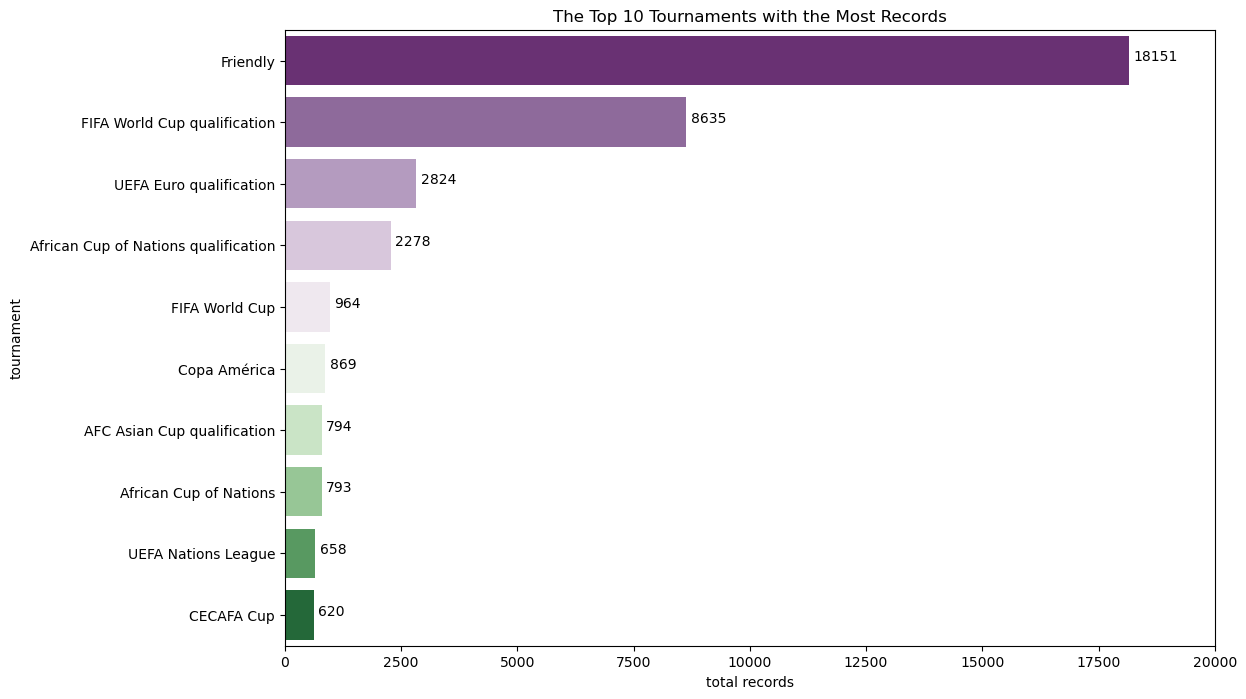

In [19]:
# plot the top 10 tournaments
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=top_records, x='total_records', y='tournament', hue='tournament', palette='PRGn', legend=False)
ax.set_xlim(0, 20000)
ax.set_xlabel('total records')
ax.set_title('The Top 10 Tournaments with the Most Records')
for idx, row in top_records.iterrows():
    ax.text(x=row['total_records']+100, y=idx, s=row['total_records'])

In [20]:
# compute the average goals for each tournament per year
results_df['year'] = results_df['date'].dt.year
results_df['total']=results_df['home_score']+results_df['away_score']

score_df = (
    results_df.loc[[x in top_records['tournament'].to_list() for x in results_df['tournament']]]
    .groupby(['tournament', 'year'])['total']
    .mean()
    .reset_index(name='mean_score')
    .sort_values('year', ascending=True)
)
score_df.head()

,tournament,year,mean_score
283,Friendly,1872,0.0
284,Friendly,1873,6.0
285,Friendly,1874,3.0
286,Friendly,1875,4.0
287,Friendly,1876,3.5


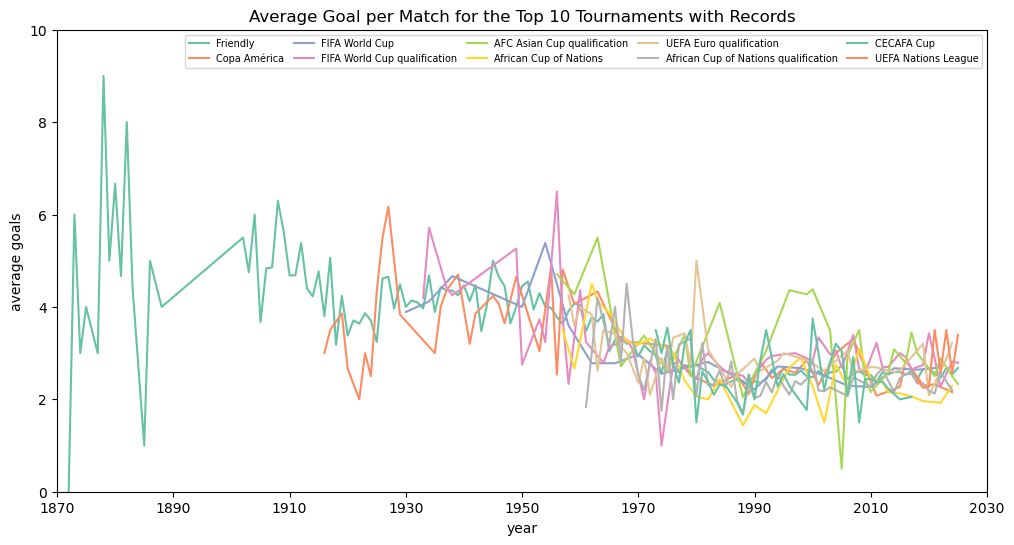

In [21]:
# plot the average goals for each tournament per year
fig, ax =plt.subplots(figsize=(12,6))
sns.lineplot(data=score_df, x='year', y='mean_score', hue='tournament', palette='Set2')
ax.legend(ncols=5, columnspacing=1, fontsize=7)
ax.set_ylim(0, 10)
ax.set_xlim(1870, 2030)
ax.set_xticks(range(1870, 2040, 20))
ax.set_ylabel('average goals')
ax.set_title('Average Goal per Match for the Top 10 Tournaments with Records')
plt.show()

In [22]:
sub_df = pd.DataFrame({
    'id':results_df.index,
    'team_home': results_df['home_team'],
    'team_away': results_df['away_team'],
    'score_home': results_df['home_score'],
    'score_away': results_df['away_score']
})
team_df = pd.wide_to_long(
    df=sub_df,
    stubnames=['team', 'score'],
    j='home_away',
    i='id',
    sep='_',
    suffix='.+'
).reset_index()

display(team_df.head())

,id,home_away,team,score
0,0,home,England,5
1,1,home,England,7
2,2,home,England,2
3,3,home,Germany,3
4,4,home,Wales,0


In [23]:
goals_df = (team_df
            .groupby('team')['score']
            .mean()
            .reset_index(name='avg_goals')
            .sort_values(by='avg_goals', ascending=False)
            .reset_index(drop=True)
)

matches_df = (team_df
            .groupby('team')
            .size()
            .reset_index(name='total_matches')
            .sort_values(by='total_matches', ascending=False)
            .reset_index(drop=True)
)

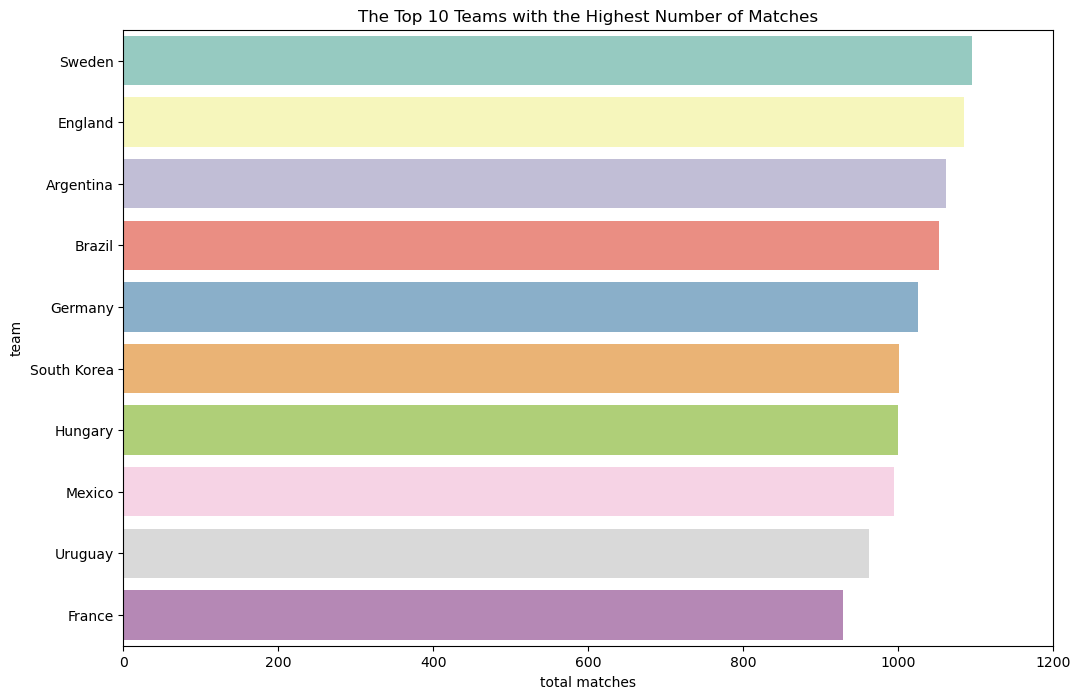

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=matches_df.iloc[:10, :], x='total_matches', y='team', hue='team', palette='Set3')
ax.set_xlim(0, 1200)
ax.set_xlabel('total matches')
ax.set_title('The Top 10 Teams with the Highest Number of Matches')
plt.show()

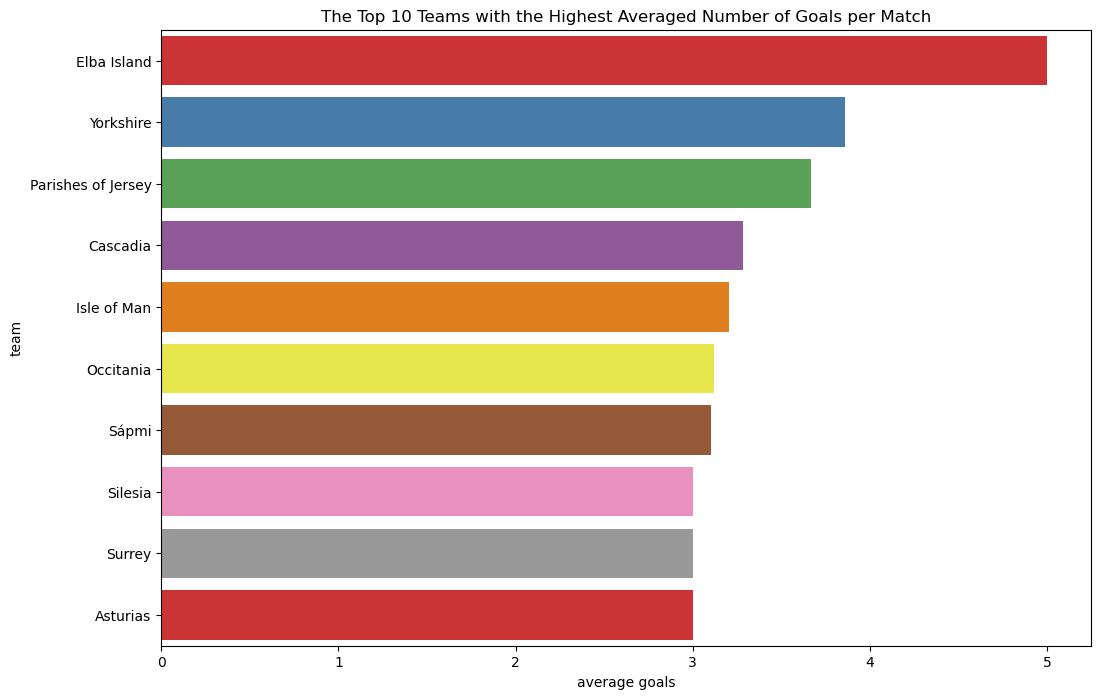

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=goals_df.iloc[:10, :], x='avg_goals', y='team', hue='team', palette='Set1')
#ax.set_xlim(0, 1200)
ax.set_xlabel('average goals')
ax.set_title('The Top 10 Teams with the Highest Averaged Number of Goals per Match')
plt.show()

## Maschine Learning for the Outcome Prediction

#### Feature selection and processing

In [26]:
# Compute the average scores for home_team/away_team in different tournaments
avg_home_df = results_df.groupby(by=['home_team', 'tournament'])['home_score'].mean().reset_index(name='avg_home_score')
avg_away_df = results_df.groupby(by=['away_team', 'tournament'])['away_score'].mean().reset_index(name='avg_away_score')
merged_df=pd.merge(left=results_df, right=avg_home_df, how='left', on=['home_team', 'tournament'])
merged_df=pd.merge(left=merged_df, right=avg_away_df, how='left', on=['away_team', 'tournament'])

# Convert neutral from boolean to int
merged_df['neutral'] = merged_df['neutral'].astype(int)

In [27]:
# Split data into training and test groups
from sklearn.model_selection import train_test_split

X = merged_df[['home_team', 'away_team', 'avg_home_score', 'avg_away_score', 'tournament', 'neutral']]
y = merged_df['winning_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)

In [28]:
# Standarize avg_home_score and avg_away_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train['avg_home_score'] = scaler.fit_transform(X_train['avg_home_score'].to_frame())
X_test['avg_home_score'] = scaler.transform(X_test['avg_home_score'].to_frame())

X_train['avg_away_score'] = scaler.fit_transform(X_train['avg_away_score'].to_frame())
X_test['avg_away_score'] = scaler.transform(X_test['avg_away_score'].to_frame())

In [ ]:
# Use label encoder to encode tournament and winnning_team
from sklearn.preprocessing import LabelEncoder
tournament_le = LabelEncoder()
winning_le = LabelEncoder()

X_train['tournament'] = tournament_le.fit_transform(X_train['tournament'])
X_test['tournament'] = tournament_le.transform(X_test['tournament'])

y_train = winning_le.fit_transform(y_train)
y_test = winning_le.transform(y_test)

In [30]:
# Use TargetEncoder to encode home_team and away_team
from sklearn.preprocessing import TargetEncoder

te = TargetEncoder( target_type='multiclass', random_state=1)

team_encoded_train = te.fit_transform(X_train[['home_team', 'away_team']], y_train)

for i in range(team_encoded_train.shape[1]):
    X_train['team_target_encoded'+str(i)] = team_encoded_train[:, i]


team_encoded_test = te.transform(X_test[['home_team', 'away_team']])

for j in range(team_encoded_test.shape[1]):
    X_test['team_target_encoded'+str(j)] = team_encoded_test[:, i]

# drop one encoded column for each variable to avoid colinearity
X_train = X_train[['team_target_encoded2', 'team_target_encoded1','team_target_encoded3','team_target_encoded5', 'avg_home_score', 'avg_away_score', 'tournament', 'neutral']]
X_test = X_test[['team_target_encoded2', 'team_target_encoded1','team_target_encoded3','team_target_encoded5', 'avg_home_score', 'avg_away_score', 'tournament', 'neutral']]


The target encoded teams are used in the models.

Alternatively, we could encode the teams using count encoder. Below is the code. 

In [ ]:
# Build a count encoder
from sklearn.preprocessing import FunctionTransformer

def count_encoding(X):
    X=X.copy()
    for col in X.columns:
        ct = X[col].value_counts()
        X[col] = X[col].map(ct)
    return X

count_encoder = FunctionTransformer(count_encoding, validate=False)

# Transform the home_team and away_team with count_encoder
count_train_subset = count_encoder.fit_transform(X_train[['home_team', 'away_team']])
X_train['home_team'] = count_train_subset['home_team']
X_train['away_team'] = count_train_subset['away_team']

count_test_subset = count_encoder.transform(X_test[['home_team', 'away_team']])
X_test['home_team'] = count_test_subset['home_team']
X_test['away_team'] = count_test_subset['away_team']


#### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Initialize Baseline
rf_model = RandomForestClassifier(random_state=42)

# Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {acc_rf:.4f}")
print("\nClassification Report (RF):")
print(classification_report(y_test, y_pred_rf, target_names=winning_le.classes_))

Training Random Forest...

Random Forest Accuracy: 0.5344

Classification Report (RF):
              precision    recall  f1-score   support

   away_team       0.46      0.60      0.52      3515
   home_team       0.60      0.72      0.66      5867
        tied       0.29      0.07      0.11      2787

    accuracy                           0.53     12169
   macro avg       0.45      0.46      0.43     12169
weighted avg       0.49      0.53      0.49     12169



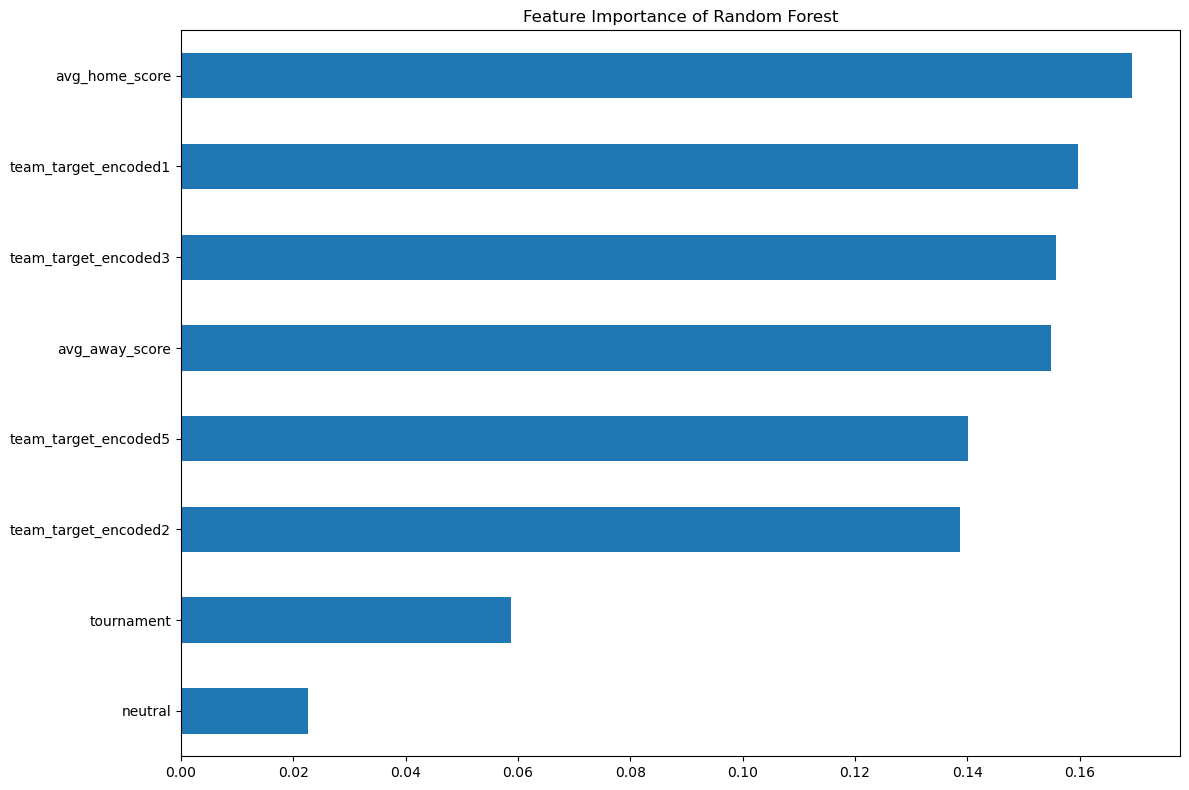

In [32]:
importances_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

importances_rf.plot(kind='barh', figsize=(12, 8))
plt.title('Feature Importance of Random Forest')
plt.tight_layout()
plt.show()

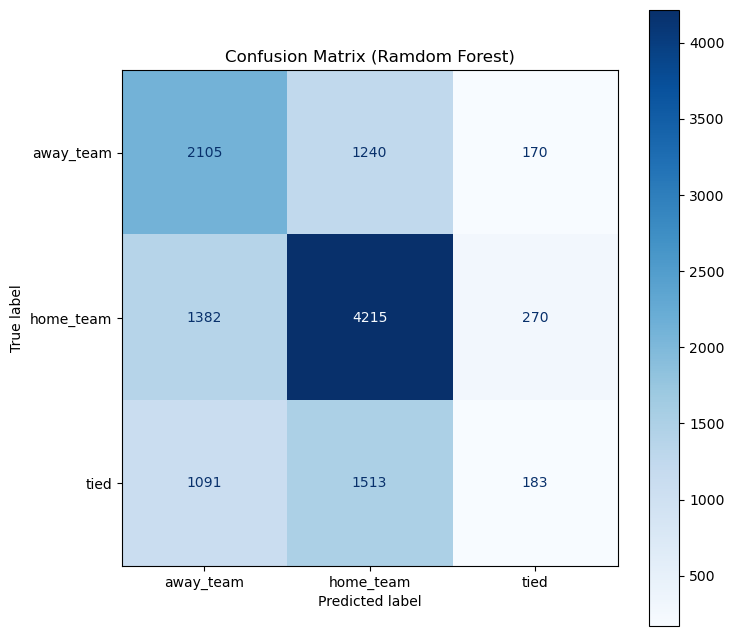

In [33]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=winning_le.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Ramdom Forest)')
plt.grid(False)
plt.show()

#### Tuning of the hyperparameters

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from skopt import BayesSearchCV

params_grid = {
    'n_estimators': np.arange(100, 301, 50).tolist(),
    'max_depth': np.arange(10, 40, 10).tolist(),
    'min_samples_split': np.arange(2, 60, 10).tolist(),
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2']
}

len(ParameterGrid(params_grid))

720

In [35]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, params_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), random_state=1)
rf_randomized = random_search.fit(X_train, y_train)
rf_randomized.best_estimator_

,n_estimators,250
,criterion,'gini'
,max_depth,10
,min_samples_split,12
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [36]:
mod2 = RandomForestClassifier(**rf_randomized.best_params_)
mod2.fit(X_train, y_train)
y_pred_randomized = mod2.predict(X_test)
print(f'The accuracy for the RandomizedSearchCV tuned parameters: {accuracy_score(y_test, y_pred_randomized):.4f}')


The accuracy for the RandomizedSearchCV tuned parameters: 0.5629


#### HalvingGridSearchCV

In [38]:
halving_grid = HalvingGridSearchCV(rf_model, params_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), factor=3, scoring='accuracy')
rf_halving = halving_grid.fit(X_train, y_train)
rf_halving.best_estimator_

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,22
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
mod3 = RandomForestClassifier(**rf_halving.best_params_)
mod3.fit(X_train, y_train)
y_pred_halving = mod3.predict(X_test)
print(f'The accuracy score for HalvingGridSearchCV tuned model: {accuracy_score(y_test, y_pred_halving):.4f}')

The accuracy score for HalvingGridSearchCV tuned model: 0.5581


#### BayesSearchCV

In [40]:
bayes_search = BayesSearchCV(rf_model, params_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
rf_bayes = bayes_search.fit(X_train, y_train)
rf_bayes.best_estimator_

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,12
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
mod4 = RandomForestClassifier(**rf_bayes.best_params_)
mod4.fit(X_train, y_train)
y_pred_bayes = mod4.predict(X_test)
print(f'The accuracy score for BayesSearchCV tuned model: {accuracy_score(y_test, y_pred_bayes):.4f}')

The accuracy score for BayesSearchCV tuned model: 0.5593


#### XGboost

In [42]:
from xgboost import XGBClassifier
from xgboost import plot_importance

xgb_model = XGBClassifier(objective='multi:softmax',
                          num_class=3,
                          eval_metric='mlogloss',
                          n_estimators=300,
                          early_stopping_rounds=20,
                          seed=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'mlogloss'


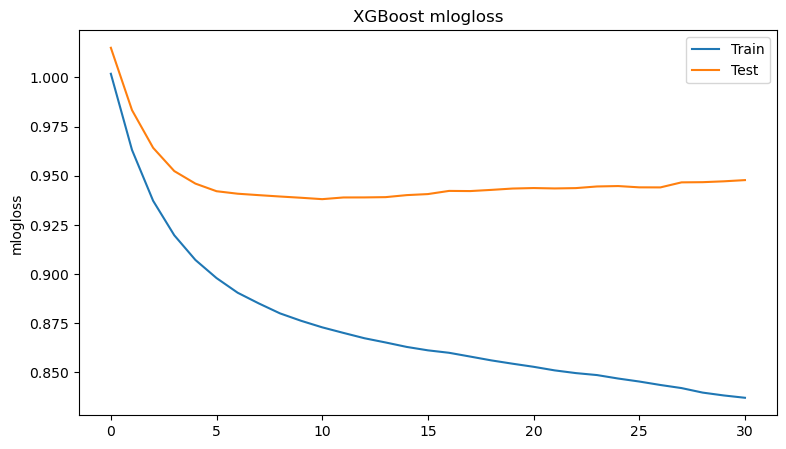

In [43]:
# preparing evaluation metric plots
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()


In [44]:
y_pred_xgb = xgb_model.predict(X_test)

print(f'The accuracy for XGboost is {accuracy_score(y_test, y_pred_xgb):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_xgb))

The accuracy for XGboost is 0.5656
Classification report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.54      3515
           1       0.60      0.82      0.69      5867
           2       0.35      0.02      0.03      2787

    accuracy                           0.57     12169
   macro avg       0.48      0.47      0.42     12169
weighted avg       0.52      0.57      0.50     12169



In [45]:
params_grid_xgb = {
    'eta': np.arange(0.05, 0.55, 0.05).tolist(),
    'max_depth': np.arange(2, 8, 1).tolist(),
    'alpha': np.arange(0.1, 1.1, 0.1).tolist(),
    'lambda': np.arange(0, 10, 1).tolist(),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

len(ParameterGrid(params_grid_xgb))

150000

In [46]:
#RandomizedSearchCV
from sklearn.utils import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

random_search_xgb = RandomizedSearchCV(xgb_model, params_grid_xgb, scoring='accuracy', cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
xgb_random = random_search_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
xgb_random.best_estimator_

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'mlogloss'


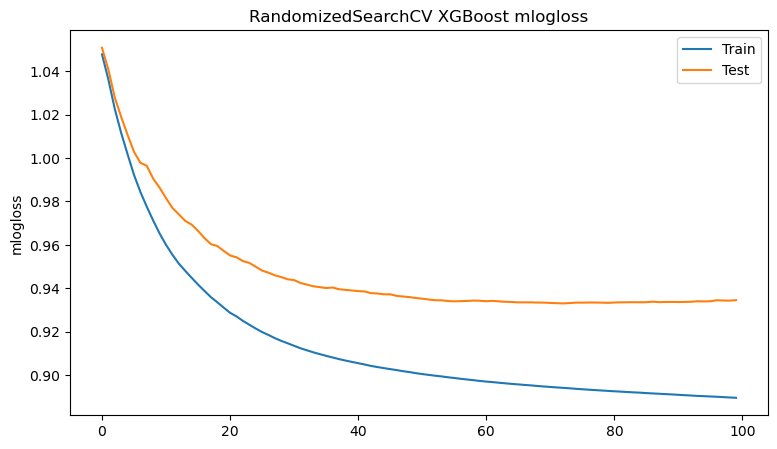

In [47]:
xgb2 = XGBClassifier(**xgb_random.best_params_)
xgb2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

# preparing evaluation metric plots
results = xgb2.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('RandomizedSearchCV XGBoost mlogloss')
plt.show()



In [48]:
y_pred_xbg_random = xgb2.predict(X_test)

print(f'The accuracy score for the RandomizedSearchCV tuned XGBoost model: {accuracy_score(y_test, y_pred_xbg_random):.4f}')
print('Classification report')
print(classification_report(y_test, y_pred_xbg_random))

The accuracy score for the RandomizedSearchCV tuned XGBoost model: 0.5656
Classification report
              precision    recall  f1-score   support

           0       0.49      0.64      0.55      3515
           1       0.61      0.79      0.69      5867
           2       0.38      0.01      0.02      2787

    accuracy                           0.57     12169
   macro avg       0.49      0.48      0.42     12169
weighted avg       0.52      0.57      0.50     12169



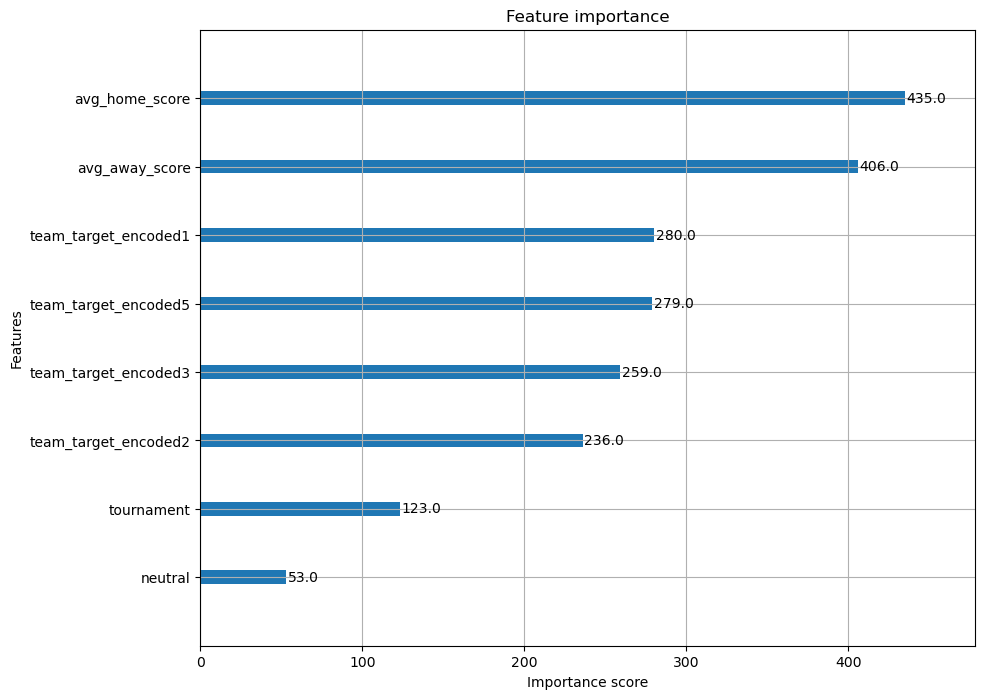

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb2, ax=ax)
plt.show()

#### Catboost

In [50]:
from catboost import CatBoostClassifier

In [51]:
# Split data into training and test groups
from sklearn.model_selection import train_test_split

X = merged_df[['home_team', 'away_team', 'avg_home_score', 'avg_away_score', 'tournament', 'neutral']]
y = merged_df['winning_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)

In [52]:
# Standarize avg_home_score and avg_away_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train['avg_home_score'] = scaler.fit_transform(X_train['avg_home_score'].to_frame())
X_test['avg_home_score'] = scaler.transform(X_test['avg_home_score'].to_frame())

X_train['avg_away_score'] = scaler.fit_transform(X_train['avg_away_score'].to_frame())
X_test['avg_away_score'] = scaler.transform(X_test['avg_away_score'].to_frame())

In [54]:
# when use catboost, it is unnecessary to encode the categorical features

cat_model=CatBoostClassifier(random_state=42, early_stopping_rounds=20)
cat_model.fit(X_train, y_train, cat_features=[0, 1, 4, 5], eval_set=(X_test, y_test), verbose=0)

y_pred_cat = cat_model.predict(X_test)
print(f'The accuracy score for the CatBoostClassifier: {accuracy_score(y_test, y_pred_cat):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred_cat))

The accuracy score for the CatBoostClassifier: 0.5827
Classification report:
              precision    recall  f1-score   support

   away_team       0.55      0.57      0.56      3515
   home_team       0.60      0.85      0.71      5867
        tied       0.34      0.03      0.05      2787

    accuracy                           0.58     12169
   macro avg       0.50      0.48      0.44     12169
weighted avg       0.53      0.58      0.51     12169



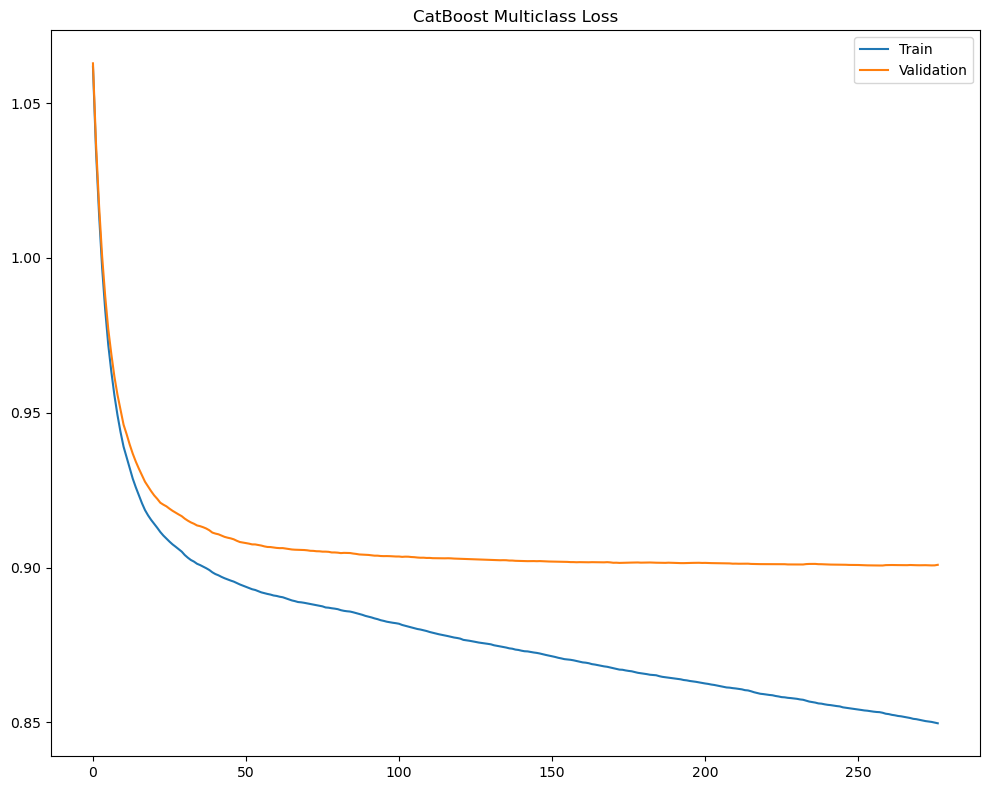

In [55]:
results1 = cat_model.evals_result_['learn']['MultiClass']
results2 = cat_model.evals_result_['validation']['MultiClass']

epochs = range(0, len(results1))

fig, ax=plt.subplots(figsize=(10, 8))
ax.plot(epochs, results1, label='Train')
ax.plot(epochs, results2, label='Validation')
ax.legend()
ax.set_title('CatBoost Multiclass Loss')
plt.tight_layout()
plt.show()

In [56]:
params_grid_cat = {
    'learning_rate': np.arange(0.01, 0.5, 0.02).tolist(),
    'depth': np.arange(5, 11, 1).tolist(),
    'l2_leaf_reg': np.arange(0, 11, 1).tolist(),
    'border_count': [2**x for x in range(8)],
    'bagging_temperature': np.arange(0, 1, 0.1).tolist(),
    'random_strength': np.arange(0, 1, 0.1).tolist()
}

len(ParameterGrid(params_grid_cat))

1320000

In [57]:
random_search_cat = RandomizedSearchCV(cat_model, params_grid_cat, scoring='accuracy', cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cat_random = random_search_cat.fit(X_train, y_train, cat_features=[0, 1, 4, 5], eval_set=(X_test, y_test), verbose=0)



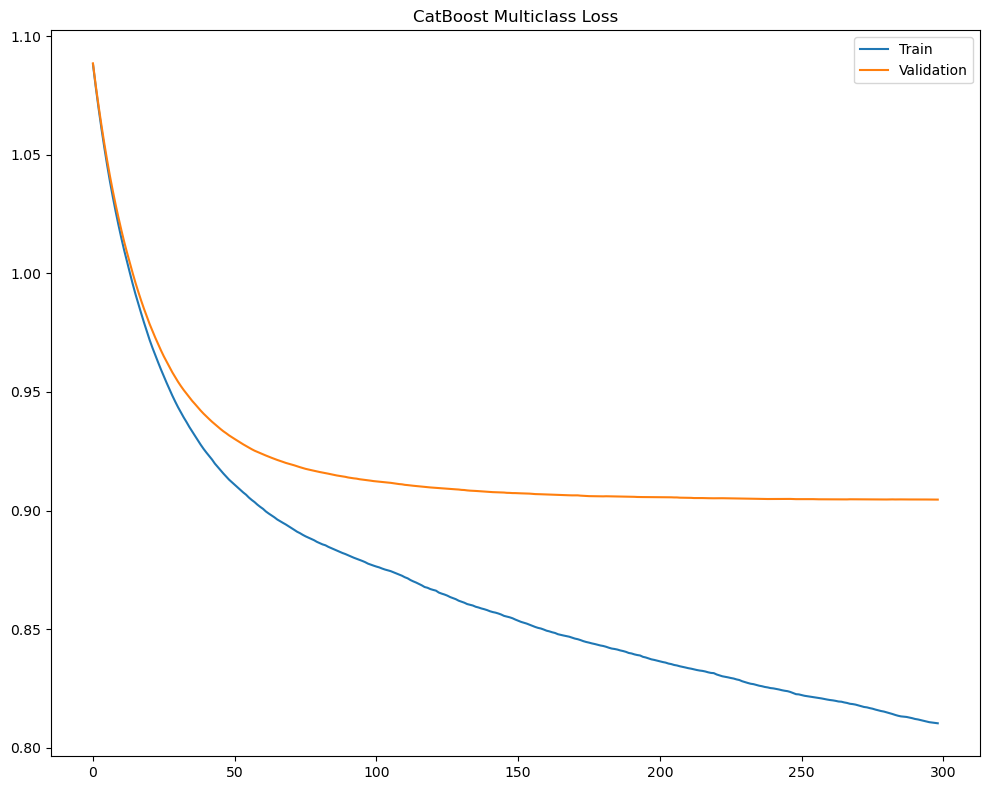

In [58]:
cat2 = CatBoostClassifier(**cat_random.best_params_, early_stopping_rounds=20)
cat2.fit(X_train, y_train, cat_features=[0, 1, 4, 5], eval_set=(X_test, y_test), verbose=0)

results1 = cat2.evals_result_['learn']['MultiClass']
results2 = cat2.evals_result_['validation']['MultiClass']

epochs = range(0, len(results1))

fig, ax=plt.subplots(figsize=(10, 8))
ax.plot(epochs, results1, label='Train')
ax.plot(epochs, results2, label='Validation')
ax.legend()
ax.set_title('CatBoost Multiclass Loss')
plt.tight_layout()
plt.show()

In [59]:
print(f'The accuracy score for the tuned CatBoostClassfier: {accuracy_score(y_test, cat2.predict(X_test)):.4f}')
print('Classification report')
print(classification_report(y_test, cat2.predict(X_test)))

The accuracy score for the tuned CatBoostClassfier: 0.5821
Classification report
              precision    recall  f1-score   support

   away_team       0.55      0.56      0.56      3515
   home_team       0.60      0.86      0.71      5867
        tied       0.32      0.02      0.04      2787

    accuracy                           0.58     12169
   macro avg       0.49      0.48      0.43     12169
weighted avg       0.52      0.58      0.51     12169



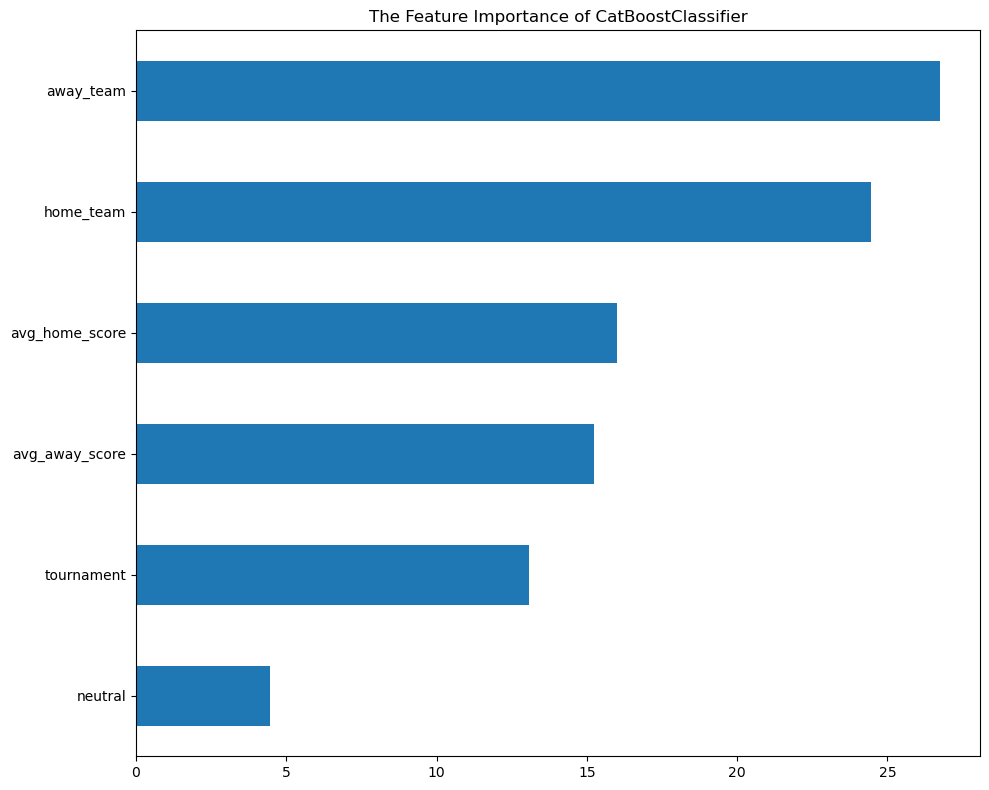

In [60]:
cat_importances = pd.Series(cat2.get_feature_importance(), index=X_train.columns).sort_values()
fig, ax = plt.subplots(figsize=(10, 8))
cat_importances.plot(kind='barh')
ax.set_title('The Feature Importance of CatBoostClassifier')
plt.tight_layout()
plt.show()